In [1]:
import keras_core as ks
from keras_core import ops
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
from kgcnn.literature.GCN import make_model, make_model_weighted
from kgcnn.data.utils import ragged_tensor_from_nested_numpy
from kgcnn.training.scheduler import LinearLearningRateScheduler

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

from kgcnn.data.datasets.MutagenicityDataset import MutagenicityDataset

Using TensorFlow backend


## Load Data

In [2]:
model_inputs = [
    {'shape': (None, 14), 'name': "node_attributes", 'dtype': 'float32'},
    {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32'},
    {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64'},
    {"shape": (), "name": "total_nodes", "dtype": "int64"},
    {"shape": (), "name": "total_edges", "dtype": "int64"}
]

In [3]:
dataset = MutagenicityDataset()
dataset.map_list(method="count_nodes_and_edges")
for i in range(len(dataset)):
    # Make edge feature dimension
    dataset[i]["edge_attributes"] = np.expand_dims(dataset[i]["edge_attributes"], axis=-1).astype(np.float32)
    # Make One-Hot encoding
    dataset[i]["node_attributes"] = np.array(np.expand_dims(dataset[i]["node_attributes"] ,axis=-1) == np.array(
        [[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]]), dtype="int") 
train_indices, test_indices = train_test_split(np.arange(len(dataset)),  train_size=0.8, random_state=1)
dataset_train, dataset_test = dataset[train_indices], dataset[test_indices]
xtrain = dataset_train.tensor(model_inputs)
xtest = dataset_test.tensor(model_inputs)
ytrain = dataset_train.tensor({"name": "graph_labels"})
ytest = dataset_test.tensor({"name": "graph_labels"})
print([x.shape for x in xtrain])
print([x.shape for x in xtest])
print(ytrain.shape, ytest.shape)

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name Mutagenicity
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting zip file. Stopped.
INFO:kgcnn.data.Mutagenicity:Reading dataset to memory with name Mutagenicity
INFO:kgcnn.data.Mutagenicity:Shift start of graph ID to zero for 'Mutagenicity' to match python indexing.
INFO:kgcnn.data.Mutagenicity:Graph index which has unconnected '[  38  133  166  171  220  246  268  278  286  296  302  305  309  339
  357  439  470  497  527  706  743  783  815  861  878  902  918 1029
 1040 1044 1057 1085 1193 1233 1329 1394 1431 1525 1528 1532 1609 1645
 1696 1915 1971 2024 2026 2036 2069 2133 2138 2142 2143 2174 2193 2210
 2234 2258 2360 2422 2440 2471 2482 2483 2503 2553 2559 2604 2627 26

[(3469, 103, 14), (3469, 216, 1), (3469, 216, 2), (3469,), (3469,)]
[(868, 99, 14), (868, 224, 1), (868, 224, 2), (868,), (868,)]
(3469, 1) (868, 1)


## Load and train model

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'GCN', 'inputs': [{'shape': (None, 14), 'name': 'node_attributes', 'dtype': 'float32'}, {'shape': (None, 1), 'name': 'edge_attributes', 'dtype': 'float32'}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64'}, {'shape': (), 'name': 'total_nodes', 'dtype': 'int64'}, {'shape': (), 'name': 'total_edges', 'dtype': 'int64'}], 'input_tensor_type': 'padded', 'input_embedding': None, 'cast_disjoint_kwargs': {}, 'input_node_embedding': {'input_dim': 55, 'output_dim': 64}, 'input_edge_embedding': {'input_dim': 10, 'output_dim': 64}, 'gcn_args': {'units': 64, 'use_bias': True, 'activation': 'relu', 'pooling_method': 'mean'}, 'depth': 3, 'verbose': 10, 'node_pooling_args': {'pooling_method': 'scatter_sum'}, 'output_embedding': 'graph', 'output_to_tensor': None, 'output_tensor_type': 'padded', 'output_mlp': {'use_bias': [True, True, False], 'units': [140, 70, 1], 'activation': ['relu', 'relu', 'sigmoid']}, 'output_scaling': None}'.


Model: "GCN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ node_attributes (InputLayer)  │ (None, None, 14)          │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_nodes (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ edge_indices (InputLayer)     │ (None, None, 2)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ total_edges (InputLayer)      │ (None)                    │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 14), (None),      │           0 │ node_attributes[0][0],         │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_nodes[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ edge_attributes (InputLayer)  │ (None, None, 1)           │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_indices_to_disj… │ [(None, 14), (2, None),   │           0 │ node_attributes[0][0],         │
│ (CastBatchedIndicesToDisjoin… │ (None), (None), (None),   │             │ edge_indices[0][0],            │
│                               │ (None), (None), (None)]   │             │ total_nodes[0][0],             │
│                               │                           │             │ total_edges[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │         960 │ cast_batched_attributes_to_di… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ cast_batched_attributes_to_d… │ [(None, 1), (None),       │           0 │ edge_attributes[0][0],         │
│ (CastBatchedAttributesToDisj… │ (None), (None)]           │             │ total_edges[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn (GCN)                     │ (None, 64)                │       4,160 │ dense[0][0],                   │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn_1 (GCN)                   │ (None, 64)                │       4,160 │ gcn[0][0],                     │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ cast_batched_indices_to_disjo… │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ gcn_2 (GCN)                   │ (None, 64)                │       4,160 │ gcn_1[0][0],                   │
│                               │                           │             │ cast_batched_attributes_to_di… │
│                               │                           │             │ 

 Total params: 32,480 (126.88 KB)

 Trainable params: 32,480 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Print Time for taining:  388.046875


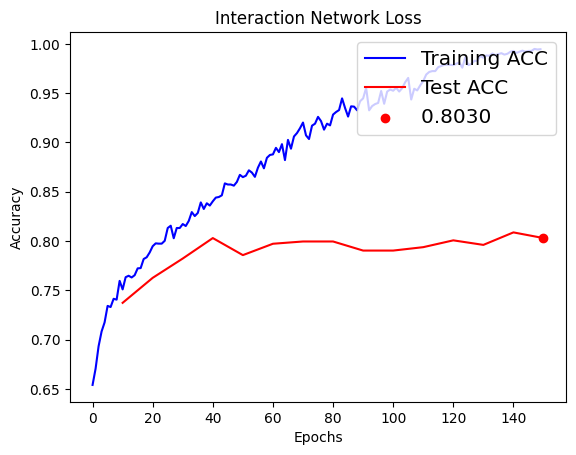

In [4]:
model_args = {
    'name': "GCN",
    'inputs': model_inputs,
    'input_edge_embedding': {"input_dim": 10, "output_dim": 64},
    'input_node_embedding': {"input_dim": 55, "output_dim": 64},
    'gcn_args': {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean'},
    'depth': 3, 'verbose': 10,
    'output_embedding': 'graph',
    'output_mlp': {"use_bias": [True, True, False], "units": [140, 70, 1],
                "activation": ['relu', 'relu', 'sigmoid']}
}
model_args2 = {
    'name': "GCN_weighted",
    'inputs': [
            {'shape': (None, 14), 'name': "node_attributes", 'dtype': 'float32'},
            {'shape': (None, 1), 'name': "node_weights", 'dtype': 'float32'},
            {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32'},
            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64'},
            {"shape": (), "name": "total_nodes", "dtype": "int64"},
            {"shape": (), "name": "total_edges", "dtype": "int64"}
    ],
    'input_edge_embedding': {"input_dim": 10, "output_dim": 64},
    'input_node_embedding': {"input_dim": 55, "output_dim": 64},
    'gcn_args': {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean'},
    'depth': 3, 'verbose': 10,
    'output_embedding': 'graph',
    'output_mlp': {"use_bias": [True, True, False], "units": [140, 70, 1],
                 "activation": ['relu', 'relu', 'sigmoid']}
}
model = make_model(**model_args)
model_node_weights = make_model_weighted(**model_args2)
# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = ks.optimizers.Adam(learning_rate=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=0
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag_2.png')
plt.show()

## We have to implement the ExplainableGCN from the GNNInterface

In [5]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()

        # Here we modify the gcn model to allow node weights
        self.gnn_model = gnn_model

    def predict(self, gnn_input, masking_info=None):
        gnn_input = [ops.convert_to_tensor(x) for x in gnn_input]
        node_input, edge_input, edge_index_input, node_len, edge_len = gnn_input
        node_weights = ops.expand_dims(ops.ones(ops.shape(node_input)[:2], dtype=node_input.dtype), axis=-1)
        return self.gnn_model([node_input, node_weights, edge_input, edge_index_input, node_len, edge_len], training=False)[0]

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input, node_len, edge_len = gnn_input

        node_len = ops.convert_to_tensor(node_len)
        edge_len = ops.convert_to_tensor(edge_len)
        edge_index_input = ops.convert_to_tensor(edge_index_input)
        
        masked_edge_input = ops.convert_to_tensor(edge_input)[0] * ops.cast(edge_mask, dtype="float32")
        masked_edge_input = ops.expand_dims(masked_edge_input, axis=0)  # dummy batch dim
  
        masked_feature_input = ops.convert_to_tensor(node_input) * ops.cast(ops.transpose(feature_mask), dtype="float32")

        node_weights = ops.sigmoid(ops.cast(ops.convert_to_tensor(node_mask), dtype="float32"))
        node_weights =  ops.expand_dims(node_weights, axis=0)  # dummy batch dim

        masked_pred = self.gnn_model([masked_feature_input, node_weights, masked_edge_input, edge_index_input, node_len, edge_len],
                                     training=training)[0]
        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        return gnn_input[0][0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        return gnn_input[0].shape[2]

    def get_number_of_edges(self, gnn_input):
        return gnn_input[1][0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        feature_relevance = np.array(feature_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        num_nodes = gnn_input[3][0]
        num_edges = gnn_input[4][0]
        for i in range(num_nodes):
            f = features[i]
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i in range(num_edges):
            e = edges[i]
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance

    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        # element_labels = np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
        element_labels = ['H', 'Li', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'K', 'Ca', 'Br', 'I']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0, 0, 0, relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r, g, b, a = plt.get_cmap('tab20')(element)
            node_color_map.append((r, g, b, graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2, figsize=(8, 12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels), explanation[1], color=bar_colors)

In [6]:
# Transfer weights
model_node_weights.set_weights(model.get_weights())
# Instanciate a Explainable GNN:
explainable_gcn = ExplainableGCN(model_node_weights)

In [7]:
# Find the 100 most mutagenic molecules, according to the GNN:
pred = model.predict(xtest)[:,0]
print(np.argsort(pred)[:100])

# Select instance to explain
instance_index = 297

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step       
[595 554 367 500 537 417 709 832 819 635 379 134 840 248 691 260 805  70
 281 443 313  55 809 779 312  35 297  90 649  41   1 276 170 550 419 867
 633 723 218  98 264 811 410  43 466  15 387  85  44 408 353 324 237  59
 256 859 790 347 584 334 461 848 317 699 103  36 530 196 233 597 596 857
 611 615 733 292 369 102  63 808 602 715 418  67  68 167 524 643 684 316
   9 497 422 534 273 143 388 559 528  16]


Setup an GNNExplainer and explain the instance:

In [8]:
compile_options = {'loss': 'binary_crossentropy', 'optimizer': ks.optimizers.Adam(learning_rate=0.1)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.005,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0.0001,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0.0001,
                 'node_mask_norm_ord': 1}

explainer = GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest])
#explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest], output_to_explain=np.array([0.]))

<Figure size 640x480 with 0 Axes>

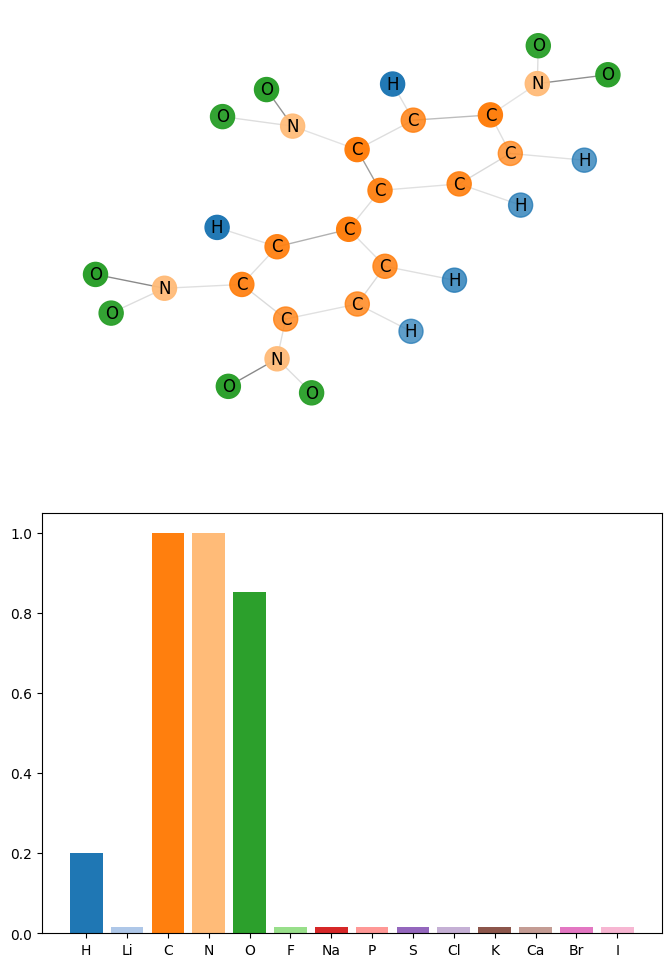

In [9]:
# Let's look at the explanation the GNNExplainer found:
plt.figure()
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)
plt.show()

If we do not specify the output_to_explain as parameter to the explain method the Explainer
will explain why the GNN came to its conclusion.
For molecules which are classified as non-mutagenic by the GNN,
the GNNExplainer will then explain why they are non-mutagenic.
We can also specify output_to_explain to be tf.Variable([0.]).
This way we can tell the Explainer to explain why a molecule could be mutagenic
even for molecules which are classified as most likely non-mutagenic by the GNN):

<Figure size 640x480 with 0 Axes>

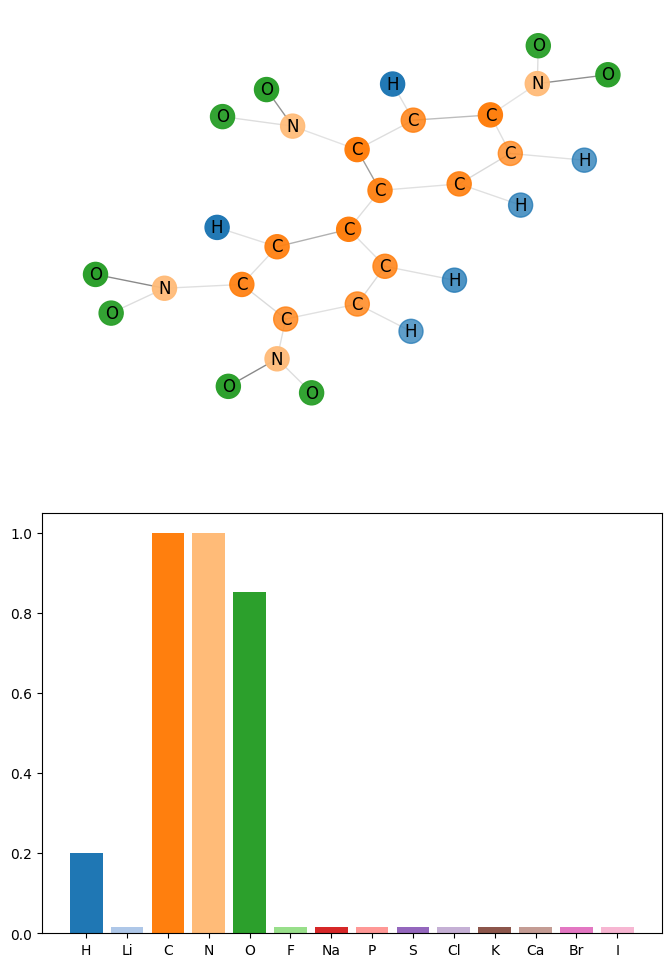

In [10]:
plt.figure()
explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest], output_to_explain=np.array([0.]))
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)
plt.show()